In [1]:
import os
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
MFCC_ROOT = r"C:\Users\ahnta\Desktop\Audio_Databse\MFCC\Speakers"
MODEL_ROOT = r"C:\Users\ahnta\Desktop\Audio_Databse\GMM_Models\Speakers"

GENDERS = ["Male", "Female"]
N_COMPONENTS = 512

In [3]:
def load_mfcc(path):
    return np.genfromtxt(path, delimiter=',', dtype=float, autostrip=True)

def get_speaker_id(filename):
    return filename.split("_")[0]

def gmm_score(gmm, mfcc):
    return np.mean(gmm.score_samples(mfcc))

In [4]:
def load_models_2min_512(gender):
    models = {}

    gender_path = os.path.join(MODEL_ROOT, gender)

    for speaker in os.listdir(gender_path):
        model_path = os.path.join(
            gender_path, speaker, "2min", f"{speaker}_512.gmm"
        )
        if os.path.exists(model_path):
            models[speaker] = joblib.load(model_path)

    return models

In [5]:
def collect_test_files(gender):
    test_files = []

    base = os.path.join(MFCC_ROOT, gender)

    for speaker in os.listdir(base):
        sp_path = os.path.join(base, speaker)

        for lang in os.listdir(sp_path):
            test_dir = os.path.join(sp_path, lang, "test")
            if not os.path.isdir(test_dir):
                continue

            for f in os.listdir(test_dir):
                if f.endswith(".mfcc"):
                    test_files.append(os.path.join(test_dir, f))

    return test_files

In [6]:
def identify_speakers(gender):
    print(f"\n===== Speaker Identification ({gender}) =====")

    models = load_models_2min_512(gender)
    test_files = collect_test_files(gender)

    y_true = []
    y_pred = []
    rows = []

    for file_path in test_files:
        filename = os.path.basename(file_path)
        true_speaker = get_speaker_id(filename)
        mfcc = load_mfcc(file_path)

        best_score = -np.inf
        best_speaker = None

        for speaker, gmm in models.items():
            score = gmm_score(gmm, mfcc)
            if score > best_score:
                best_score = score
                best_speaker = speaker

        y_true.append(true_speaker)
        y_pred.append(best_speaker)

        rows.append({
            "test_file": filename,
            "true_speaker": true_speaker,
            "predicted_speaker": best_speaker,
            "best_score": best_score
        })

    return y_true, y_pred, pd.DataFrame(rows)


===== Speaker Identification (Male) =====


<Figure size 1000x1000 with 0 Axes>

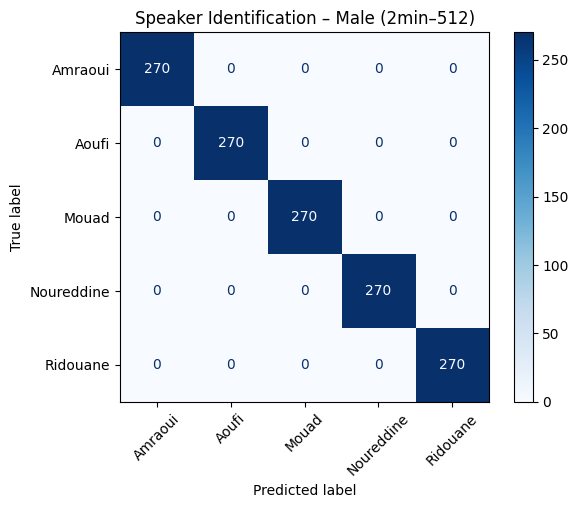

CSV saved: speaker_identification_male_2min_512.csv

===== Speaker Identification (Female) =====


<Figure size 1000x1000 with 0 Axes>

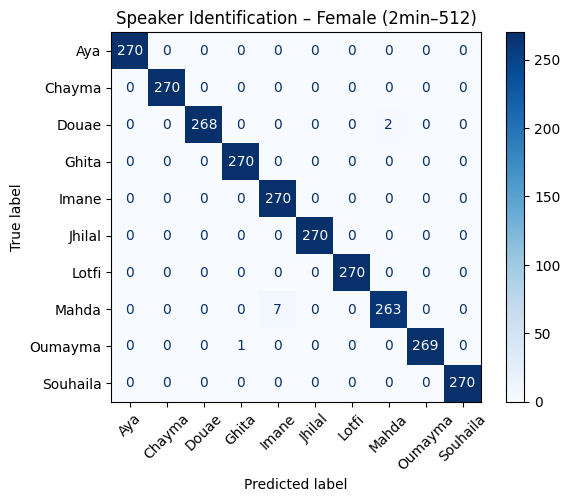

CSV saved: speaker_identification_female_2min_512.csv


In [7]:
for gender in GENDERS:
    y_true, y_pred, df = identify_speakers(gender)

    # Confusion matrix
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    plt.figure(figsize=(10, 10))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Speaker Identification – {gender} (2min–512)")
    plt.grid(False)
    plt.show()

    # Save CSV
    csv_path = f"speaker_identification_{gender.lower()}_2min_512.csv"
    df.to_csv(csv_path, index=False)
    print(f"CSV saved: {csv_path}")